In [23]:
import os
import torch, torch.utils, torch.utils.data
import torchvision
import torch.backends.cudnn as cudnn
import config, datasets,dataloaders, trainer, model_manager, inference, metric

import importlib
# importlib.reload(config)

cudnn.benchmark = True

In [24]:
# Initialize the configuration
conf = config.Config(
    num_classes=10,  # CIFAR10 classes
    train_ratio=0.8,
    val_ratio=0.2,
    num_epochs=20,
    lr=0.01,
    batch_size=64,
    num_workers=4,
    device=torch.device("cuda:0"),
    momentum=0.0001,
    weight_decay=0.0001,
    train_dir="data/train/",
    test_dir="data/test/",
    log_dir="./log/",
    checkpoint_dir="./log/checkpoint/",
    metric_file_path="./log/metric_results.json",
)
os.makedirs(conf.checkpoint_dir, exist_ok=True)

In [25]:
# Define the data transformation pipeline for the training set
train_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandAugment(),
        torchvision.transforms.ToTensor(),
        # https://github.com/facebookarchive/fb.resnet.torch/issues/180
        torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
    ]
)
# Define the data transformation pipeline for the test set
test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        # https://github.com/facebookarchive/fb.resnet.torch/issues/180
        torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
    ]
)

In [26]:
# Initialize a custom dataset instance for CIFAR10 with specific transformations for training and testing
ds = datasets.CustomDatasets(
    standard_dataset_name="CIFAR10",
    train_transform=train_transform,
    test_transform=test_transform,
)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
# Create a custom dataset loader with the specified batch size and number of worker processes
dl = dataloaders.CustomDatasetLoader(batch_size=conf.batch_size, num_workers=conf.num_workers)
# Split the labeled dataset into training and validation sets based on the specified ratios
ds.split_labeled_dataset(train_ratio=conf.train_ratio, val_ratio=conf.val_ratio, enable_test_split=False)
# Set the test transformation for the validation dataset
ds.set_transform(ds.split_val_dataset, ds.test_transform)

Split train_datasets => split_train_dataset and split_val_dataset
ratio train : val = 0.8 : 0.2


In [28]:
# Print the transformations set for the training, validation, and test datasets
ds.print_set_transform(ds.split_train_dataset, "train")
ds.print_set_transform(ds.split_val_dataset, "val")
ds.print_set_transform(ds.labeled_test_dataset, "test")

train is set : Compose(
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ToTensor()
    Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616])
)
val is set : Compose(
    ToTensor()
    Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616])
)
test is set : Compose(
    ToTensor()
    Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616])
)


In [29]:
# Build data loaders for the labeled training, validation, and test datasets
dl.build_dataloaders(
    labeled_train_dataset=ds.split_train_dataset,
    labeled_val_dataset=ds.split_val_dataset,
    labeled_test_dataset=ds.labeled_test_dataset,
    unlabeled_test_dataset=None,
)

In [1]:
# Initialize a ResNet50 model without pre-trained weights
model = torchvision.models.resnet50(weights=None)
# Replace the fully connected layer with a new one matching the number of classes in the dataset
model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=conf.num_classes)
# Initialize the loss function as CrossEntropyLoss without class weights
loss_fn = torch.nn.CrossEntropyLoss(weight=None)
# Initialize the optimizer as Stochastic Gradient Descent with specified learning rate, momentum, and weight decay
optimizer = torch.optim.SGD(
    params=model.parameters(), lr=conf.lr, momentum=conf.momentum, weight_decay=conf.weight_decay
)
# Calculate the total number of iterations for the learning rate scheduler
n_iterations = len(dl.labeled_train_loader) * conf.num_epochs
# Initialize the learning rate scheduler as CosineAnnealingLR with the total number of iterations
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_iterations)
# Initialize a ModelManager instance to handle the training, evaluation, and saving of the model
mm = model_manager.ModelManager(
    model=model, device=conf.device, loss_fn=loss_fn, optimizer=optimizer, lr_scheduler=lr_scheduler
)

NameError: name 'torchvision' is not defined

In [2]:
# Initialize an ImageClassificationTrainer instance for managing the training process
trainer = trainer.ImageClassificationTrainer(
    model_manager=mm,
    train_loader=dl.labeled_train_loader,
    val_loader=dl.labeled_val_loader,
    total_epochs=conf.num_epochs,
    log_dir=conf.log_dir,
    checkpoint_dir=conf.checkpoint_dir,
)

NameError: name 'trainer' is not defined

In [32]:
# Start the training process
trainer.train()

100%|██████████| 20/20 [03:16<00:00,  9.80s/it]


In [33]:
# Reload the inference module (useful if there have been changes during runtime)
#importlib.reload(inference)

# Load the trained model weights from the checkpoint file
loaded_weights = torch.load(conf.checkpoint_dir + "model_20.pth")
mm.model.load_state_dict(loaded_weights)
test = inference.ImageClassifierInference(
    model_manager=mm,
    test_loader=dl.labeled_test_loader,
    num_classes=conf.num_classes,
    metric_file_path=conf.metric_file_path,
)
# Perform inference on the test dataset and obtain predictions
test.predict(is_classes=True)

  0%|          | 0/157 [00:00<?, ?it/s]

/home/developer/.local/lib/python3.10/site-packages/torcheval/metrics/functional/classification/accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:224.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")
100%|██████████| 157/157 [00:01<00:00, 138.63it/s]


<Axes: >

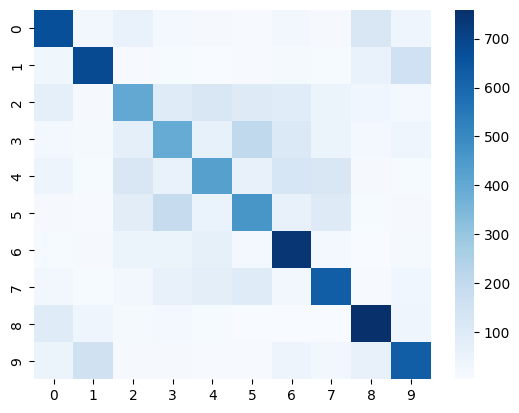

In [34]:
import json
import seaborn as sns

# Load the computed metrics from the specified file
with open(conf.metric_file_path) as f:
    metric = json.loads(f.read())
# Create a heatmap of the confusion matrix using seaborn
sns.heatmap(metric["ConfusionMatrix"], cmap="Blues")

In [35]:
import pandas as pd

# Create a DataFrame from the metric data and display it
df = pd.DataFrame(data=metric,index=ds.labeled_train_dataset.classes)
df

,Accuracy,Precision,Recall,F1,AUROC,AUPRC,Accuracy_per_class,Precision_per_class,Recall_per_class,F1_per_class,AUROC_per_class,AUPRC_per_class,ConfusionMatrix
airplane,0.579,0.573456,0.579,0.574579,0.916095,0.625618,0.669,0.640805,0.669,0.654599,0.939190,0.720367,"[669.0, 26.0, 59.0, 22.0, 15.0, 8.0, 25.0, 15...."
automobile,0.579,0.573456,0.579,0.574579,0.916095,0.625618,0.683,0.698364,0.683,0.690597,0.960154,0.760155,"[36.0, 683.0, 9.0, 11.0, 6.0, 8.0, 16.0, 12.0,..."
bird,0.579,0.573456,0.579,0.574579,0.916095,0.625618,0.402,0.470726,0.402,0.433657,0.847317,0.442928,"[75.0, 15.0, 402.0, 98.0, 120.0, 100.0, 92.0, ..."
cat,0.579,0.573456,0.579,0.574579,0.916095,0.625618,0.392,0.426551,0.392,0.408546,0.862802,0.394915,"[24.0, 18.0, 75.0, 392.0, 63.0, 207.0, 111.0, ..."
deer,0.579,0.573456,0.579,0.574579,0.916095,0.625618,0.430,0.500582,0.430,0.462614,0.883985,0.497967,"[45.0, 10.0, 120.0, 60.0, 430.0, 61.0, 129.0, ..."
dog,0.579,0.573456,0.579,0.574579,0.916095,0.625618,0.463,0.472449,0.463,0.467677,0.892084,0.505102,"[14.0, 8.0, 86.0, 190.0, 52.0, 463.0, 62.0, 99..."
frog,0.579,0.573456,0.579,0.574579,0.916095,0.625618,0.740,0.589641,0.740,0.656319,0.944647,0.730646,"[11.0, 15.0, 46.0, 51.0, 71.0, 23.0, 740.0, 21..."
horse,0.579,0.573456,0.579,0.574579,0.916095,0.625618,0.626,0.613124,0.626,0.619495,0.930082,0.705837,"[27.0, 11.0, 27.0, 61.0, 82.0, 98.0, 29.0, 626..."
ship,0.579,0.573456,0.579,0.574579,0.916095,0.625618,0.759,0.695692,0.759,0.725968,0.962261,0.803283,"[97.0, 40.0, 17.0, 20.0, 12.0, 4.0, 6.0, 4.0, ..."
truck,0.579,0.573456,0.579,0.574579,0.916095,0.625618,0.626,0.626627,0.626,0.626313,0.938425,0.694984,"[46.0, 152.0, 13.0, 14.0, 8.0, 8.0, 45.0, 27.0..."
